# Import libraries

In [1]:
# torch 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms.functional as F
from torch.utils.data import Dataset
from torchvision.utils import save_image


# PIL 
from PIL import Image

# plotting
import seaborn as sns 
from matplotlib import pyplot as plt

# Other
import numpy as np
import os
import pandas as pd
from random import random
from tqdm import tqdm 
import warnings
warnings.filterwarnings("ignore")

### Check cuda availability

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:    
    print('Not connected to a GPU')
else:
    print(gpu_info)

cuda = torch.cuda.is_available()

Fri Jan 20 09:29:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

# Load Datasets

In [3]:
!mkdir "./datasets"

## CIFAR100

In [4]:
def img_to_tensor(im):
    t = torch.tensor(np.array(im.convert('RGB'))/255, dtype=torch.float32).permute(2, 0, 1)
    return  t * 2 - 1

In [5]:
class MyCifar100(Dataset):
    def __init__(self, root, augmentation, train=True, download=True):
        super(MyCifar100, self).__init__()
        
        self.root = root
        
        self.cifar100 = datasets.CIFAR100(root=self.root, train=train, download=download)
        self.augmentation = augmentation
        
    
    def __getitem__(self, ix):
        
        x, y = self.cifar100[ix]
        
        x = img_to_tensor(x)
        x_aug = self.augmentation(x)
        
        return x, x_aug, y

    def __len__(self):
        
        return len(self.cifar100)

In [6]:
cifar100_train = MyCifar100(root="./datasets", augmentation=F.hflip, train=True, download=True)
cifar100_test = MyCifar100(root="./datasets", augmentation=F.hflip, train=False, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./datasets/cifar-100-python.tar.gz to ./datasets
Files already downloaded and verified


In [7]:
# data loader parameters
batch_size = 10
dataloader_num_worker = 1

# train data loader
train_dataloader = torch.utils.data.DataLoader(
    cifar100_train,
    batch_size=batch_size,
    num_workers=dataloader_num_worker,
    pin_memory=True,
    drop_last=False,
    shuffle=False
)

# test data loader 
test_dataloader = torch.utils.data.DataLoader(
    cifar100_test,
    batch_size=batch_size,
    num_workers=dataloader_num_worker,
    pin_memory=True,
    drop_last=False,
    shuffle=False
)

### Some Training Samples

In [8]:
def stick_images(dataloader, num_rows, num_cols, random=False):
    w, h = dataloader[0][0].size
    N = num_rows * num_cols
    indecies = list()
    if random:
        pass
    else:
        indecies = [ix for ix in range(N)]
        
    image = Image.new("RGB", size=(w*num_cols, h*num_rows))
    
    for ix in indecies:
        data, _ = dataloader[ix]
        image.paste(data, ((ix%num_cols)*w, (ix//num_cols)*h) )
        
#     image.resize((32*4*, 32*4*2), Image.NEAREST)

    return image
        

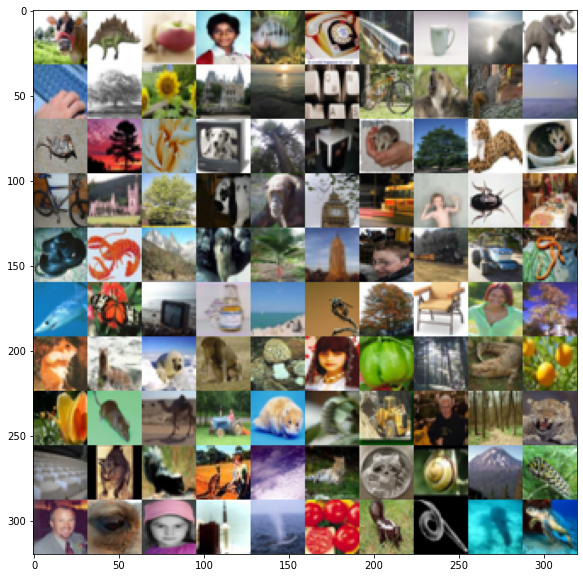

In [9]:
sticked_image_train = stick_images(cifar100_train.cifar100, num_rows=10, num_cols=10)

plt.figure(figsize=(10,10))

plt.imshow(sticked_image_train)

### Some Testing Samples

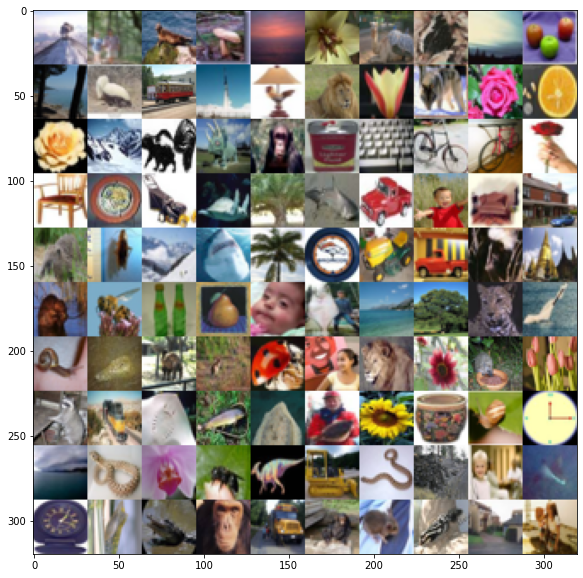

In [10]:
sticked_image_test = stick_images(cifar100_test.cifar100, num_rows=10, num_cols=10)

plt.figure(figsize=(10,10))

plt.imshow(sticked_image_test)

## MNIST

### Define distortion

In [11]:
from torchvision import transforms
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(0., 1.)
])

In [12]:

def distort(x, num_pixels=1, value=1.0):
    for _ in range(num_pixels):
        x[0][int(random()*28)][int(random()*28)] = value
    return x

transform=transforms.Compose([
                   transforms.ToPILImage(),
                   transforms.ToTensor(),
                   transforms.Lambda(lambda x: distort(x, num_pixels=48)),
                   # the above line was added compared to the original model
                   transforms.Normalize((0.1307,), (0.3081,))])

In [14]:
class MyMNIST(Dataset):
    def __init__(self, root, augmentation, train=True, download=True):
        super(MyMNIST, self).__init__()
        self.root = root
        self.mnist = datasets.MNIST(root=self.root, train=train, download=download,transform=transforms.ToTensor())
        self.augmentation = augmentation

    def __getitem__(self, ix):   
        x, y = self.mnist[ix] 
        x_aug = self.augmentation(x)
        return x, x_aug, y
    
    def __len__(self):
        return len(self.mnist)

In [15]:
mnist_train = MyMNIST(root="./datasets", augmentation=transform, train=True, download=True)
mnist_test = MyMNIST(root="./datasets", augmentation=transform, train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [16]:
# data loader parameters
batch_size = 64
dataloader_num_worker = 1

# train data loader
train_dataloader = torch.utils.data.DataLoader(
    mnist_train,
    batch_size=batch_size,
    num_workers=dataloader_num_worker,
    pin_memory=True,
    drop_last=False,
    shuffle=False
)

# test data loader 
test_dataloader = torch.utils.data.DataLoader(
    mnist_test,
    batch_size=batch_size,
    num_workers=dataloader_num_worker,
    pin_memory=True,
    drop_last=False,
    shuffle=False
)

### Some Training Samples

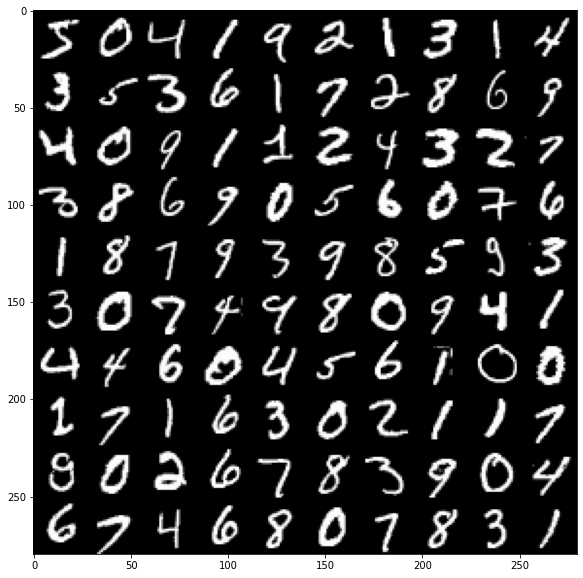

In [17]:
sticked_image_train = stick_images(mnist_train.mnist, num_rows=10, num_cols=10)

plt.figure(figsize=(10,10))

plt.imshow(sticked_image_train)

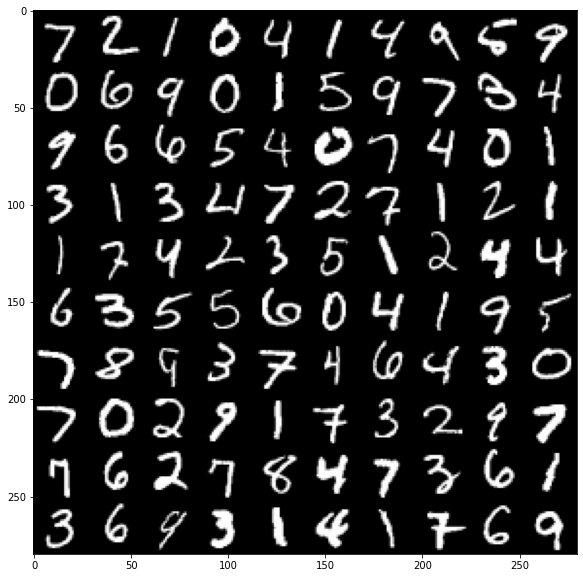

In [18]:
sticked_image_test = stick_images(mnist_test.mnist, num_rows=10, num_cols=10)

plt.figure(figsize=(10,10))

plt.imshow(sticked_image_test)

# Classifier architecture

In [21]:
class MyAlexNet(nn.Module):
    def __init__(self, input_size, num_feature_layers = 12, num_classes=100, feature_denoiser=None):
        super(MyAlexNet, self).__init__()

        self.input_size = input_size
        
        # selecting frist 'num_feature_layers' layers of alexnet as backbone modle
        self.num_feature_layers = num_feature_layers
        self.backbone = self.get_feature_network()[:num_feature_layers]

        # average pooling layer
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(6, 6))
        self.avgpool = nn.MaxPool2d(kernel_size=2)

        self.num_classes = num_classes

        # diffusion-based feature denoiser
        self.feature_denoiser = feature_denoiser

        # calculating feature size
        classifier_in_size = self.get_classifier_in_size()

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=classifier_in_size, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=self.num_classes, bias=True))

    def get_classifier_in_size(self):
        rand_in = torch.randn((1, self.input_size[0], self.input_size[1], self.input_size[2]))
        y = self.backbone(rand_in)
        y = self.avgpool(y)
        y = torch.flatten(y, 1)
        return y.shape[1]

        
        
        
    def forward(self, x):
        feature = self.backbone(x)
        feature = self.avgpool(feature)
        feature = torch.flatten(feature, 1)

        if self.feature_denoiser is not None:
            # denoising the feature 
            feature = self.feature_denoiser.backward(feature)
        y = self.classifier(feature)
        return y, feature

    def representation(self, x):
        rep = self.backbone(x)
        rep = self.avgpool(rep)
        rep = torch.flatten(rep, 1).squeeze(dim=3).squeeze(dim=2)
        return rep

    def fix_backbone(self):
        for param in self.backbone.parameters():
            param.requires_grad = False
    
    def get_feature_network(self):
        return nn.Sequential(
                    nn.Conv2d(self.input_size[0], 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
                    nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
                    nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False))

# Training Classifier

### Training utilities

In [22]:
class AverageMeter(object):
    """computes and stores the average and current value"""

    def __init__(self, start_val=0, start_count=0, start_avg=0, start_sum=0):
        self.reset()
        self.val = start_val
        self.avg = start_avg
        self.sum = start_sum
        self.count = start_count

    def reset(self):
        """
        Initialize 'value', 'sum', 'count', and 'avg' with 0.
        """
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, num=1):
        """
        Update 'value', 'sum', 'count', and 'avg'.
        """
        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count


def save_model(file_path, file_name, model, optimizer=None):
    """
    In this function, a model is saved.Usually save model after training in each epoch.
    ------------------------------------------------
    Args:
        - model (torch.nn.Module)
        - optimizer (torch.optim)
        - file_path (str): Path(Folder) for saving the model
        - file_name (str): name of the model checkpoint to save
    """
    state_dict = dict()
    state_dict["model"] = model.state_dict()

    if optimizer is not None:
        state_dict["optimizer"] = optimizer.state_dict()
    torch.save(state_dict, os.path.join(file_path, file_name))


def load_model(ckpt_path, model, optimizer=None):
    """
    Loading a saved model and optimizer (from checkpoint)
    """
    checkpoint = torch.load(ckpt_path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["model"])
    if (optimizer != None) & ("optimizer" in checkpoint.keys()):
        optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            # correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            correct_k = correct[:k].float().sum()
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res


### Learning and Evaluation 

In [23]:
class Trainner:
    def __init__(
            self,
            model_name,
            batch_size,
            epochs,
            learning_rate,
            device,
            load_saved_model,
            ckpt_save_freq,
            ckpt_save_path,
            ckpt_path,
            report_path):
        
        self.model_name = model_name
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.device = device
        self.load_saved_model = load_saved_model
        self.ckpt_save_freq = ckpt_save_freq
        self.ckpt_save_path = ckpt_save_path
        self.ckpt_path = ckpt_path
        self.report_path = report_path

    def train(self,
              train_loader,
              test_loader):

        global model, optimizer, report
        model = MyAlexNet(input_size=(1,28,28), num_feature_layers=5, num_classes=10).to(self.device)

        # loss function
        criterion = nn.CrossEntropyLoss()

        # optimzier
        optimizer = optim.Adam(model.parameters(), lr=self.learning_rate)

        if self.load_saved_model:
            model, optimizer = load_model(
                ckpt_path=self.ckpt_path, model=model, optimizer=optimizer)

        # fixing backbone
        model.fix_backbone()
        
        report = pd.DataFrame(
            columns=["model_name",
                     "mode",
                     "image_type",
                     "epoch",
                     "learning_rate",
                     "batch_size",
                     "batch_index",
                     "loss_batch",
                     "avg_train_loss_till_current_batch",
                     "avg_train_top1_acc_till_current_batch",
                     "avg_test_loss_till_current_batch",
                     "avg_test_top1_acc_till_current_batch"])
        
        for epoch in tqdm(range(1, self.epochs + 1)):
            top1_acc_train = AverageMeter()
            loss_avg_train = AverageMeter()
            top1_acc_test = AverageMeter()
            loss_avg_test = AverageMeter()

            model.train()
            mode = "train"
            loop_train = tqdm(
                enumerate(train_loader, 1),
                total=len(train_loader),
                desc="train",
                position=0,
                leave=True,)
            
            
            for batch_idx, (images,_,labels) in loop_train:
                images = images.to(device).float()
                labels = labels.to(device)
                labels_pred,_ = model(images)
                loss = criterion(labels_pred, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                acc1 = accuracy(labels_pred, labels)
                top1_acc_train.update(acc1[0], images.size(0))
                loss_avg_train.update(loss.item(), images.size(0))

                report = report.append(
                    {"model_name": self.model_name,
                     "mode": mode,
                     "image_type":"original",
                     "epoch": epoch,
                     "learning_rate":self.learning_rate,
                     "batch_size": images.size(0),
                     "batch_index": batch_idx,
                     "loss_batch": loss.detach().item(),
                     "avg_train_loss_till_current_batch":loss_avg_train.avg,
                     "avg_train_top1_acc_till_current_batch":top1_acc_train.avg},ignore_index=True,)

                loop_train.set_description(f"Train - iteration : {epoch}")
                loop_train.set_postfix(
                    loss_batch="{:.4f}".format(loss.detach().item()),
                    avg_train_loss_till_current_batch="{:.4f}".format(loss_avg_train.avg),
                    top1_accuracy_train = "{:.4f}".format(top1_acc_train.avg),
                    refresh=True,)
            if epoch % self.ckpt_save_freq == 0:
                save_model(
                    file_path=self.ckpt_save_path,
                    file_name=f"ckpt_{self.model_name}_epoch{epoch}.ckpt",
                    model=model,
                    optimizer=optimizer)

            model.eval()
            mode = "test"
            with torch.no_grad():
                loop_test = tqdm(
                    enumerate(test_loader, 1),
                    total=len(test_loader),
                    desc="test",
                    position=0,
                    leave=True,)
                for batch_idx, (images,_,labels) in loop_test:
                    optimizer.zero_grad()
                    images = images.to(device).float()
                    labels = labels.to(device)
                    labels_pred,_ = model(images)
                    loss = criterion(labels_pred, labels)
                    acc1 = accuracy(labels_pred, labels)
                    top1_acc_test.update(acc1[0], images.size(0))
                    loss_avg_test.update(loss.item(), images.size(0))  
                    report = report.append(
                        {"model_name": self.model_name,
                         "mode": mode,
                         "image_type":"original",
                         "epoch": epoch,
                         "learning_rate":self.learning_rate,
                         "batch_size": images.size(0),
                         "batch_index": batch_idx,
                         "loss_batch": loss.detach().item(),
                         "avg_test_loss_till_current_batch":loss_avg_test.avg,
                         "avg_test_top1_acc_till_current_batch":top1_acc_test.avg},ignore_index=True,)

                    loop_test.set_description(f"Test - iteration : {epoch}")
                    loop_test.set_postfix(
                        loss_batch="{:.4f}".format(loss.detach().item()),
                        avg_test_loss_till_current_batch="{:.4f}".format(loss_avg_test.avg),
                        top1_accuracy_test = "{:.4f}".format(top1_acc_test.avg),
                        refresh=True,)
    #         scheduler.step()
        report.to_csv(f"{self.report_path}/{self.model_name}_report.csv")
        return model, optimizer, report

    def eval(
        self,
        model,
        device,
        test_dataloader):
        model = model.to(self.device)
        # Reporting stuffs
        #   - top 1 accuracy
        top1_acc_orginal = AverageMeter()
        top1_acc_augmented = AverageMeter()
        #   - average loss
        loss_avg_orginal = AverageMeter()
        loss_avg_augmented = AverageMeter()
   
        mode = "test"
        with torch.no_grad():
            loop_test = tqdm(
                enumerate(test_loader, 1),
                total=len(test_loader),
                desc="test",
                position=0,
                leave=True,)
            for batch_idx, (original_images,augmented_images,labels) in loop_test:
                optimizer.zero_grad()
                original_images = original_images.to(self.device).float()
                augmented_images = augmented_images.to(self.device).float()
                labels = labels.to(self.device)
                
                
                labels_pred_original,_ = model(original_images)
                labels_pred_augmented,_ = model(augmented_images)
                
                
                loss_original = criterion(labels_pred_original, labels)
                acc1_original = accuracy(labels_pred_original, labels)
                
                loss_augmented = criterion(labels_pred_augmented, labels)
                acc1_augmented = accuracy(labels_pred_augmented, labels) 
                
                
                top1_acc_orginal.update(acc1_original[0], original_images.size(0))
                loss_avg_orginal.update(loss_original.item(), original_images.size(0))  

                top1_acc_augmented.update(acc1_augmented[0], augmented_images.size(0))
                loss_avg_augmented.update(loss_augmented.item(), augmented_images.size(0))                  
                
                loop_test.set_description(f"Evaluation - ")
                loop_test.set_postfix(
                    loss_org = loss_avg_original.avg,
                    loss_aug = loss_avg_augmented.avg,
                    acc1_org = top1_acc_orginal.avg,
                    acc1_aug = top1_acc_augmented.avg,
                    refresh=True,)

        return_values ={"original": {"loss": loss_avg_original.avg,
                                      "acc_top1": top1_acc_orginal.avg},
            
                         "augmented": {"loss": loss_avg_augmented.avg,
                                       "acc_top1": top1_acc_augmented.avg}}

        return return_values

### Training

In [24]:
###################            Parameters      ############################
batch_size = 1024
epochs = 100
learning_rate = 1e-3
ckpt_save_freq = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


###################            DataLoader(s)      ############################

# train data loader
train_dataloader = torch.utils.data.DataLoader(
                                mnist_train,
                                batch_size=batch_size,
                                pin_memory=True,
                                drop_last=False,
                                shuffle=True)


# test data loader 
test_dataloader = torch.utils.data.DataLoader(
                                mnist_test,
                                batch_size=batch_size,
                                pin_memory=True,
                                drop_last=False,
                                shuffle=True)

#################            Training process      ############################

trainer = Trainner(model_name='Alexnet',
                   batch_size=batch_size,
                   epochs=epochs,
                   learning_rate=learning_rate,
                   device=device,
                   load_saved_model=False,
                   ckpt_save_freq=ckpt_save_freq,
                   ckpt_save_path='./',
                   ckpt_path='./',
                   report_path='./')

alexnet_model, alexnet_optimizer, alexnet_report = trainer.train(train_loader=train_dataloader,
                                                                test_loader=test_dataloader)

 58%|█████▊    | 58/100 [49:25<35:47, 51.13s/it]


KeyboardInterrupt: 

# EDA

In [120]:
def plot_metric(reports,
                models_name,
                cols,
                title,
                metric_name,
                figsize,
                xylabel_fontsize,
                xy_ticks_fontsize,
                legend_fontsize,
                title_fontsize,
                linewidth_plot):

    metric_train_name = "avg_train_loss_till_current_batch"
    metric_test_name = "avg_test_loss_till_current_batch"

    ##########    Prepare metric data    ##############
    train_reports = [report[report["mode"] == "train"] for report in reports]
    test_reports = [report[report["mode"] == "test"] for report in reports]

    last_trains_batch_id = [
        train_report["batch_index"].max() for train_report in train_reports
    ]
    last_tests_batch_id = [
        test_report["batch_index"].max() for test_report in test_reports
    ]
    report_trains_last_index, report_tests_last_index = [], []
    current_metric_trains, current_metric_tests = [], []

    for index in range(len(reports)):
        report_trains_last_index.append(
            train_reports[index][
                train_reports[index].batch_index == last_trains_batch_id[index]
            ]
        )
        report_tests_last_index.append(
            test_reports[index][
                test_reports[index].batch_index == last_tests_batch_id[index]
            ]
        )
        current_metric_trains.append(
            report_trains_last_index[index][cols[0]].values
        )
        current_metric_tests.append(
            report_tests_last_index[index][cols[1]].values
        )

    ##############    Plot   ################
    fig, ax = plt.subplots(1, figsize=figsize)
    fig.suptitle(
        f"Train and test loss",y=0.95, fontsize=title_fontsize
    )

    for model_index in range(len(models_name)):
        ax.plot(
            current_metric_trains[model_index],
            linewidth=linewidth_plot,
            label=f"Train - {models_name[model_index]}",
        )
        ax.plot(
            current_metric_tests[model_index],
            linewidth=linewidth_plot,
            label=f"Test - {models_name[model_index]}",
        )

    ##########    Change Properties    ##############
    ax.set_xlabel("Epoch", fontsize=xylabel_fontsize)
    ax.set_ylabel(metric_name, fontsize=xylabel_fontsize)
    ax.grid(axis="y", alpha=0.5)
    ax.legend(loc=0, prop={"size": legend_fontsize})
    ax.tick_params(axis="x", labelsize=xy_ticks_fontsize)
    ax.tick_params(axis="y", labelsize=xy_ticks_fontsize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.show()

## Train and test loss

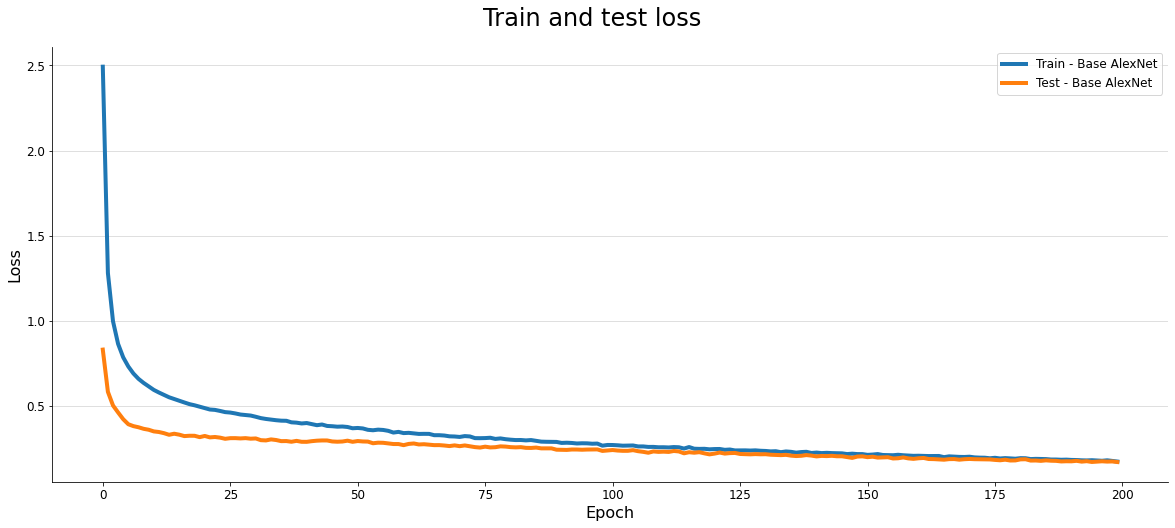

In [163]:
plot_metric(
            reports=[alexnet_report],
            models_name=['Base AlexNet'],
            cols = ["avg_train_loss_till_current_batch","avg_test_loss_till_current_batch"],
            title="Train and Test Accuracy",
            metric_name  = "Loss",
            figsize=(20,8),
            xylabel_fontsize=16,
            xy_ticks_fontsize=12,
            legend_fontsize=12,
            title_fontsize=24,
            linewidth_plot=4)

### Train and test accuracy

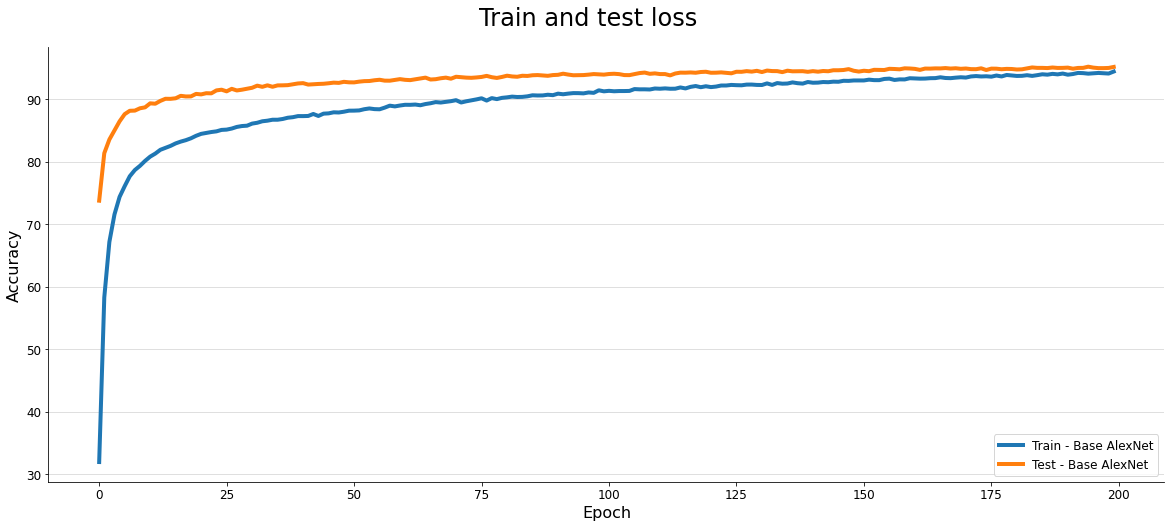

In [164]:
plot_metric(
            reports=[alexnet_report],
            models_name=['Base AlexNet'],
            cols = ["avg_train_top1_acc_till_current_batch","avg_test_top1_acc_till_current_batch"],
            title="Train and Test Accuracy",
            metric_name  = "Accuracy",
            figsize=(20,8),
            xylabel_fontsize=16,
            xy_ticks_fontsize=12,
            legend_fontsize=12,
            title_fontsize=24,
            linewidth_plot=4)

# Diffusion Model

### Noise Predictor

In [23]:
class Encoder1D(nn.Module):
    def __init__(self, layers_size, time_emb_dim=32):

        super().__init__()

        self.layers = list()
        for (in_size, out_size) in zip(layers_size[:-1], layers_size[1:]):
            self.layers.append(
                        nn.Sequential(
                        nn.BatchNorm1d(in_size),
                        nn.Linear(in_size, out_size),
                        nn.GELU()))
        self.layers = nn.Sequential(*self.layers)
        self.time_emb_layer = nn.Sequential(
                        nn.SiLU(),
                        nn.Linear(
                        time_emb_dim,
                        layers_size[-1]))

    def forward(self, delta, x, t):
        out = self.layers( torch.cat([delta, x], dim=1) )
        t_emb = self.time_emb_layer(t)
        return out + t_emb

torch.Size([10, 128])

In [26]:
class Decoder1D(nn.Module):
    def __init__(self, layers_size, time_emb_dim=32):
        super().__init__()
        self.layers = list()
        for (in_size, out_size) in zip(layers_size[:-1], layers_size[1:]):
            self.layers.append(
                nn.Sequential(
                    nn.BatchNorm1d(in_size),
                    nn.Linear(in_size, out_size),
                    nn.GELU()))
        self.layers = nn.Sequential(*self.layers)
        self.time_emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                time_emb_dim,
                layers_size[-1]))
    def forward(self, x, t):
        out = self.layers(x)
        t_emb = self.time_emb_layer(t)
        return out + t_emb

True

In [40]:
class UNet1D(nn.Module):
    def __init__(self, in_size, cond_size, time_emb_dim=32, device=torch.device("cpu")):

        super().__init__()

        self.time_emb_dim = time_emb_dim
        self.device = device

        # ---------------- Encoder ----------------
        enc_layers_size = [
            in_size + cond_size,
            in_size, 
            in_size//2
        ]
        
        self.encoder = Encoder1D(layers_size=enc_layers_size, time_emb_dim=time_emb_dim)
        
        # ---------------- Decoder ----------------
        dec_layers_size = [
            in_size // 2,
            3 * in_size // 4,
            in_size
        ]

        self.decoder = Decoder1D(layers_size=dec_layers_size, time_emb_dim=time_emb_dim)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, cond, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_emb_dim)

        # Encoding
        out_enc = self.encoder(x, cond, t)

        # Decoding
        out_dec = self.decoder(out_enc, t)

        return out_dec


delta = torch.randn(batch_size, feature_dim)
x = torch.randn(batch_size, feature_dim)
t = torch.tensor([10] * batch_size).long()

unet = UNet1D(in_size=feature_dim, cond_size=feature_dim, time_emb_dim=time_emb_dim)

predicted_noise = unet(delta, x, t)

predicted_noise.shape == x.shape

True

## Diffusion Model

In [41]:
class Diffusion1D(nn.Module):
    def __init__(
            self, 
            input_size,
            time_emb_dim=32,
            noise_steps=1000, 
            beta_start=1e-4, 
            beta_end=0.02, 
            device="cuda"
            ):
        super().__init__()

        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.input_size = input_size 

        self.device = device

        self.noise_predictor = UNet1D(
                                      in_size=self.input_size, 
                                      cond_size=self.input_size, 
                                      time_emb_dim=time_emb_dim,
                                      device=device
                                     )

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
        
    def sample_time(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def forward(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def backward(self, cond):
        out = torch.randn(batch_size, self.input_size)

        for ix in range(self.noise_steps):
            
            step = self.noise_steps-ix-1
            t = torch.tensor(step, dtype=torch.long).cuda()

            with torch.no_grad():
                pred_noise = self.noise_predictor(out, cond, t)

                # parameters of step 't'
                alpha_t = self.alpha[t][:, None]
                alpha_hat_t = self.alpha_hat[t][:, None]
                beta_t = self.beta[t][:, None]

                # µ
                noise_coef = (1 - alpha_t) / (1 - alpha_hat_t)**0.5
                mu = 1 / (alpha_t**0.5) * (out - noise_coef * pred_noise)

                # Σ
                sigma = beta_t ** 0.5

                # ε: noise
                if step > 1:
                    epsilon = torch.randn_like(out)
                else:
                    epsilon = torch.zeros_like(out)

                # Updating output 
                out = mu + sigma * epsilon

        return out
        

# Training Diffusion Model

In [ ]:
!mkdir "./diffusion"

In [ ]:
def diffusion_train(train_loader,
                    test_loader,
                    saved_model_classifier,
                    to_train_classifier,
                    to_fix_backbone,
                    input_size,
                    feature_dim,
                    time_emb_dim,
                    noise_steps,
                    beta_start,
                    beta_end,
                    model_name,
                    batch_size,
                    epochs,
                    learning_rate,
                    device,
                    ckpt_save_freq,
                    ckpt_save_path,
                    ckpt_path,
                    report_path):

#     global model_classifier,model_denoiser,optimizer, report
    
    model_classifier = MyAlexNet(input_size=input_size, num_feature_layers=5, num_classes=10).to(device)
    
    if saved_model_classifier is not None:
#         model_classifier, _ = load_model(ckpt_path=ckpt_path, model=model_classifier, optimizer=None)
        model_classifier = saved_model_classifier

    unet = UNet1D(in_size=feature_dim, cond_size=feature_dim, time_emb_dim=time_emb_dim).to(device)

    # feature size
    x_random = torch.randn([1] + list(input_size))
    x_random = x_random.to(device)

    feature_size = model(x_random)[1].shape[1]

    diffusion = Diffusion1D( 
                        input_size=feature_size,
                        time_emb_dim=time_emb_dim,
                        noise_steps=noise_steps, 
                        beta_start=beta_start, 
                        beta_end=beta_end,  
                        device=device)

    diffusion = diffusion.to(device)
    # loss function
    criterion = nn.MSELoss()

    # optimzier

    if to_train_classifier:
        optimizer = optim.AdamW([*unet.parameters(), *model.parameters()], lr=learning_rate)
    else:
        optimizer = optim.AdamW([*unet.parameters()], lr=learning_rate)

    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                             step_size=10, 
                                             gamma=0.8)

    # fixing backbone
    if to_fix_backbone:
        model_classifier.fix_backbone()

    report = pd.DataFrame(
        columns=["model_name",
                 "mode",
                 "epoch",
                 "learning_rate",
                 "batch_size",
                 "batch_index",
                 "loss_batch",
                 "avg_train_loss_till_current_batch",
                 "avg_test_loss_till_current_batch"])

    for epoch in tqdm(range(1, epochs + 1)):
        loss_avg_train = AverageMeter()
        loss_avg_test = AverageMeter()

        model.train()
        mode = "train"
        loop_train = tqdm(
            enumerate(train_loader, 1),
            total=len(train_loader),
            desc="train",
            position=0,
            leave=True,)

        for batch_idx, (X_o,X_a,labels) in loop_train:
            # migrating data to the gpu

            X_o = X_o.to(device).float()
            X_a = X_a.to(device).float()

            # output of the alexnet
            _, rep_o = model(X_o)
            _, rep_a = model(X_a)

            # Calculating difference between augmented and original image representation
            delta = rep_o - rep_a


            # ---------------- Diffusion ---------------- #
            # applying diffusion model for a random time steps
            t = diffusion.sample_time(X_o.shape[0]).to(device)

            # adding noise to the delta vector for 't' steps
            delta_t, noise = diffusion(delta, t)

            # predicting added noise to the delta vector in 't' time steps 
            # with the guaidance of augmented image representation
            predicted_noise = diffusion.noise_predictor(delta_t, rep_a, t)

            # calculating loss function
            loss = criterion(noise, predicted_noise)
            # ---------------- Optimizing ---------------- #
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # ---------------- Reporting ---------------- #

            # Updating average loss of current epoch
            loss_avg_train.update(loss.item(), X_o.size(0))

            # current learning rate
            current_lr = lr_scheduler.get_last_lr()[0]

            report = report.append(
                {"model_name": model_name,
                 "mode": mode,
                 "epoch": epoch,
                 "learning_rate":current_lr,
                 "batch_size": X_o.size(0),
                 "batch_index": batch_idx,
                 "loss_batch": loss.detach().item(),
                 "avg_train_loss_till_current_batch":loss_avg_train.avg},ignore_index=True,)

            loop_train.set_description(f"Train - iteration : {epoch}")
            loop_train.set_postfix(
                loss_batch="{:.4f}".format(loss.detach().item()),
                avg_train_loss_till_current_batch="{:.4f}".format(loss_avg_train.avg),
                learning_rate = current_lr,
                refresh=True,)
        if epoch % ckpt_save_freq == 0:
            save_model(
                file_path=ckpt_save_path,
                file_name=f"ckpt_{model_name}_epoch{epoch}.ckpt",
                model=model,
                optimizer=optimizer)

#             model.eval()
#             mode = "test"
#             with torch.no_grad():
#                 loop_test = tqdm(
#                     enumerate(test_loader, 1),
#                     total=len(test_loader),
#                     desc="test",
#                     position=0,
#                     leave=True,)
#                 for batch_idx, (images,_,labels) in loop_test:
#                     optimizer.zero_grad()
#                     images = images.to(device).float()
#                     labels = labels.to(device)
#                     labels_pred,_ = model(images)
#                     loss = criterion(labels_pred, labels)
#                     acc1 = accuracy(labels_pred, labels)
#                     top1_acc_test.update(acc1[0], images.size(0))
#                     loss_avg_test.update(loss.item(), images.size(0))  
#                     report = report.append(
#                         {"model_name": model_name,
#                          "mode": mode,
#                          "epoch": epoch,
#                          "learning_rate":current_lr,
#                          "batch_size": images.size(0),
#                          "batch_index": batch_idx,
#                          "loss_batch": loss.detach().item(),
#                          "avg_test_loss_till_current_batch":loss_avg_test.avg},ignore_index=True,)

#                     loop_test.set_description(f"Test - iteration : {epoch}")
#                     loop_test.set_postfix(
#                         loss_batch="{:.4f}".format(loss.detach().item()),
#                         avg_test_loss_till_current_batch="{:.4f}".format(loss_avg_test.avg),
#                         top1_accuracy_test = "{:.4f}".format(top1_acc_test.avg),
#                         refresh=True,)
        lr_scheduler.step()
    report.to_csv(f"{report_path}/{model_name}_report.csv")
    return model, optimizer, report

In [ ]:
saved_model_classifier =model
to_train_classifier = False
to_fix_backbone = True
input_size = (1,28,28)
feature_dim = 256
time_emb_dim=32
noise_steps=100
beta_start=1e-4
beta_end=0.02
model_name='Diffusion'
batch_size=1024
epochs=100
learning_rate=1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_saved_model=False
ckpt_save_freq=10
ckpt_save_path='./'
ckpt_path='./'
report_path='./'



###################            Parameters      ############################
batch_size = 1024
epochs = 100
learning_rate = 1e-3
ckpt_save_freq = 10


###################            DataLoader(s)      ############################

# train data loader
train_loader = torch.utils.data.DataLoader(
                                mnist_train,
                                batch_size=batch_size,
                                pin_memory=True,
                                drop_last=False,
                                shuffle=True)


# test data loader 
test_loader = torch.utils.data.DataLoader(
                                mnist_test,
                                batch_size=batch_size,
                                pin_memory=True,
                                drop_last=False,
                                shuffle=True)


diffusion_train(train_loader = train_loader,
                test_loader = test_loader,
                saved_model_classifier = saved_model_classifier,
                to_train_classifier =to_train_classifier,
                to_fix_backbone = to_fix_backbone,
                input_size = input_size,
                feature_dim = feature_dim,
                time_emb_dim = time_emb_dim,
                noise_steps = noise_steps,
                beta_start = beta_start,
                beta_end = beta_end,
                model_name = model_name,
                batch_size = batch_size,
                epochs = epochs,
                learning_rate = learning_rate,
                device = device,
                ckpt_save_freq = ckpt_save_freq,
                ckpt_save_path = ckpt_save_path,
                ckpt_path = ckpt_path,
                report_path = report_path)

# Observing some Representations

In [ ]:
deltas = list()

t_dataloader = tqdm(train_dataloader)
t_dataloader.set_description("Calculating Change Vectors:")

for ix, (X, X_aug, Y) in enumerate(t_dataloader): 

    rep_org = alexnet(X)
    rep_aug = alexnet(X_aug)
    
    delta = rep_aug - rep_org 
    deltas.append(delta) 
    
    t_dataloader.set_postfix(
        batch_index = ix
    )

deltas = torch.cat(deltas) 
cov_deltas = torch.cov(deltas.T)

Calculating Change Vectors:: 100%|██████████| 5000/5000 [01:39<00:00, 50.40it/s, batch_index=4999]


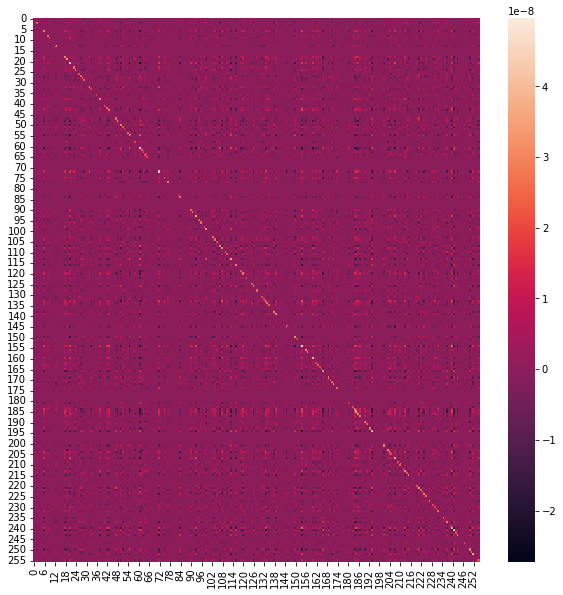

In [ ]:
ax = plt.figure(figsize=(10,10)).add_subplot(1,1,1)

sns.heatmap(cov_deltas.detach().numpy(), ax=ax)

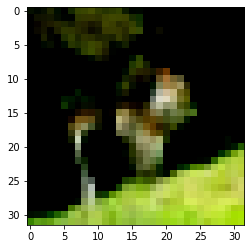

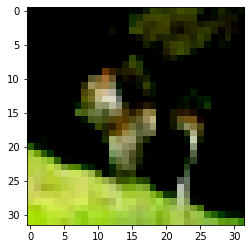

In [ ]:
index = 5

save_image(X[index], "./x_org.png")
save_image(X_aug[index], "./x_aug.png")

x_org = Image.open("./x_org.png")
x_aug = Image.open("./x_aug.png")

plt.imshow(x_org)
plt.show()

plt.imshow(x_aug)
plt.show()

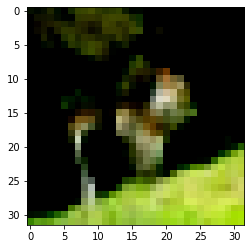

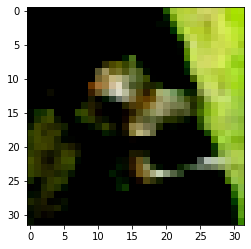

In [ ]:
x0 = X[5]
save_image(F.rotate(x0, angle=90),"./alaki.png")

plt.imshow(x_org)
plt.show()

plt.imshow(Image.open("./alaki.png"))
plt.show()